In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsummary import summary
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from IPython.display import clear_output
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from collections import defaultdict
import random
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

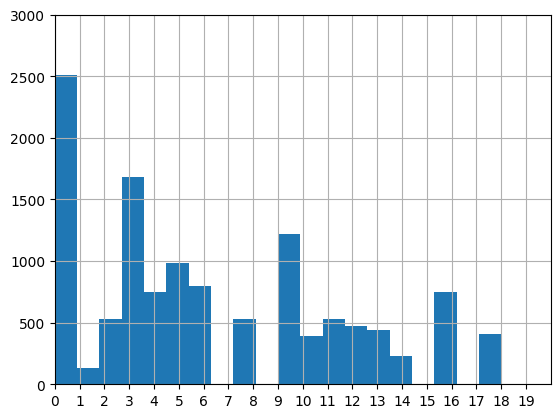

In [3]:
train_ans = pd.read_csv('human_poses_data/train_answers.csv')
vals = list(train_ans['target_feature'].values)

# plt.figure(figsize=(10, 3))
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)
plt.hist(train_ans['target_feature'].values, bins=20)
plt.show()

In [4]:
targets = list(map(int, train_ans['target_feature'].values))

index_to_target = []
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')
    index_to_target.append(target)


print()
print(index_to_target)

0 - 2512
1 - 135
2 - 530
3 - 1680
4 - 752
5 - 982
6 - 800
8 - 533
9 - 1223
10 - 390
11 - 528
12 - 469
13 - 442
14 - 228
16 - 753
18 - 410

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]


In [6]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            self.label_map = label_map

            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image
# from data.data import Data

In [ ]:
transform = Compose([
    Resize((200, 200)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize([0.5, 0.5, 0.5], [0.25, 0.25, 0.25]),
    # Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)


train_indices, valid_indices = train_test_split(
    range(len(train_data)),
    test_size=0.15,
    stratify=targets,
    random_state=42
)

# Создаем Subset'ы
train_set = Subset(train_data, train_indices)
valid_set = Subset(train_data, valid_indices)


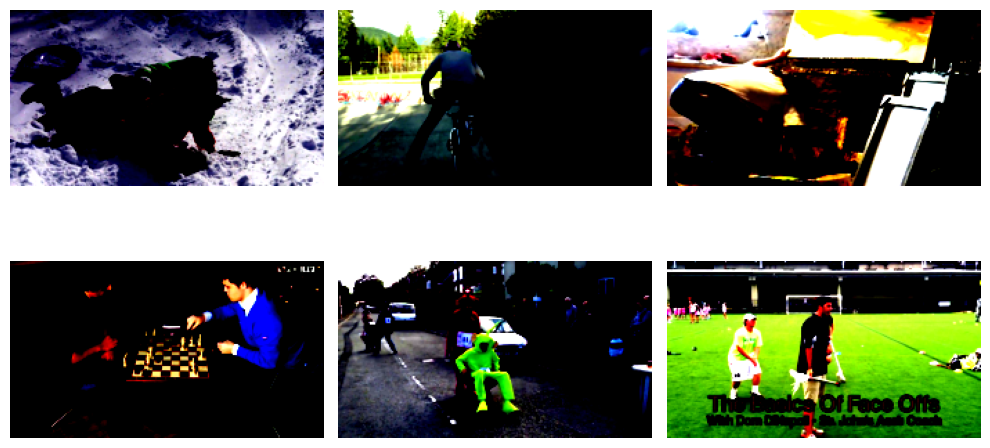

In [12]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_set, num_images=6)


In [ ]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count <= 300:
                needed = current_count * 5

            elif current_count <= 400:
                needed = current_count * 3

            elif current_count <= 500:
                needed = current_count * 2

            elif current_count <= 1000:
                needed = current_count

            elif current_count <= 1500:
                needed = int(current_count * 0.5)

            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = np.random.choice(self.augmentations, size=num_augs, replace=False).tolist()
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)


In [9]:
len(balanced_train_set)

21586

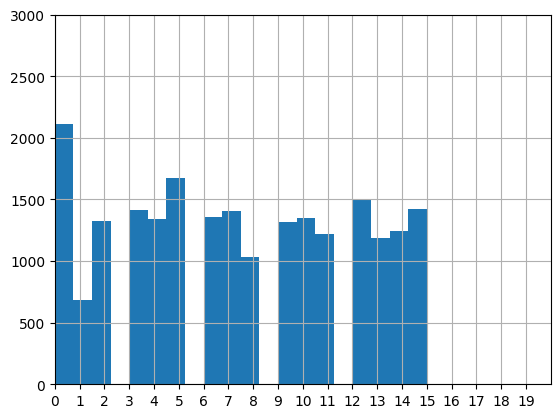

In [10]:
plt.axis((0, 20, 0, 3000))
plt.xticks(np.arange(0, 20, 1))
plt.grid(True)

targets = []
for _, target in balanced_train_set:
    targets.append(target)

plt.hist(targets, bins=20)
plt.show()

In [11]:
for target in sorted(set(targets)):
    print(f'{target} - {targets.count(target)}')


0 - 2113
1 - 684
2 - 1329
3 - 1416
4 - 1338
5 - 1674
6 - 1358
7 - 1404
8 - 1037
9 - 1316
10 - 1347
11 - 1218
12 - 1496
13 - 1188
14 - 1248
15 - 1420


In [12]:
# labels = [0, 0, 0, 1, 1, ...]  # Список всех меток
class_weights = compute_class_weight(
    "balanced", 
    classes=np.unique(targets), 
    y=targets
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


In [ ]:
BATCH_SIZE = 100

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    
    model.train() if optimizer is not None else model.eval()

    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)

            total_loss += loss.item()

            if optimizer != None:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())

            
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    else:
        return avg_loss, None, None


In [16]:
# class Model9(nn.Module):
#     def __init__(self):
#         super(Model9, self).__init__()

#         self.block1 = nn.Sequential(
#             nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  # (8, 256, 256)
#             nn.BatchNorm2d(8),
#             nn.PReLU(),

#             nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1),  # (12, 256, 256)
#             nn.BatchNorm2d(12),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (12, 128, 128)

#             nn.Conv2d(12, 16, kernel_size=3, stride=1, padding=1),  # (16, 128, 128)
#             nn.BatchNorm2d(16),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (16, 64, 64)
#         )

#         # (16, 64, 64)

#         # --------------BigSkip--------------
#         # --------------skip1--------------
#         self.block2 = nn.Sequential(
#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
#             nn.BatchNorm2d(16),
#             nn.PReLU(),

#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.PReLU(), # (32, 32, 32)
#         )
#         # --------------skip1--------------

#         # (32, 32, 32)

#         # --------------skip2--------------
#         self.block3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
#             nn.BatchNorm2d(64),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)

#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 16)
#             nn.BatchNorm2d(64),
#             nn.PReLU(),
        
#             nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),
#         )
#         # --------------skip2--------------

#         # (32, 32, 32)

#         # --------------skip3--------------
#         self.block4 = nn.Sequential(
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),

#             nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),  # (32, 64, 64)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),

#             nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
#             nn.BatchNorm2d(16),
#             nn.PReLU(),
#         )
#         # --------------skip3--------------
#         # --------------BigSkip--------------

#         # (16, 64, 64)

#         self.block5 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
#             nn.BatchNorm2d(64),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)

#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 16)
#             nn.BatchNorm2d(64),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (64, 8, 8)

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 8, 8)
#             nn.BatchNorm2d(128),
#             nn.PReLU(),
#             nn.MaxPool2d(kernel_size=2),  # (128, 4, 4)

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),  # (256, 2, 2)
#             nn.BatchNorm2d(256),
#             nn.PReLU(),
#         )
        
#         # (256, 2, 2)

#         self.skip1 = nn.Sequential(  # (16, 64, 64)
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),  # (32, 32, 32)
#         )

#         self.skip2 = nn.Sequential(  # (32, 32, 32)
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
#             nn.BatchNorm2d(32),
#             nn.PReLU(),
#         )
        
#         self.skip3 = nn.Sequential(  # (32, 32, 32)
#             nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (16, 64, 64)
#             nn.BatchNorm2d(16),
#             nn.PReLU(),  # (16, 64, 64)
#         )

#         self.bigskip = nn.Sequential(  # (16, 64, 64)
#             nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),  # (16, 64, 64)
#             nn.BatchNorm2d(16),
#             nn.PReLU(),
#         )  # (16, 64, 64)



#         self.classifier = nn.Sequential( # (256, 2, 2)
#             nn.Linear(256 * 2 * 2, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
            
#             nn.Linear(512, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),

#             nn.Linear(128, 16)
#         )

#     def forward(self, x):
#         x = self.block1(x)
#         bigskip = self.bigskip(x)

#         skip = self.skip1(x)
#         out = self.block2(x)
#         x = skip + out

#         out = self.block3(x)
#         skip = self.skip2(x)
#         x = skip + out

#         out = self.block4(x)
#         skip = self.skip3(x)
#         x = skip + out + bigskip
        
#         x = self.block5(x)

#         x = x.view(x.size(0), -1)  # Flatten
#         x = self.classifier(x)
#         return x

In [ ]:
# model = Model9().to(device)
# summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
       BatchNorm2d-2          [-1, 8, 256, 256]              16
             PReLU-3          [-1, 8, 256, 256]               1
            Conv2d-4         [-1, 12, 256, 256]             876
       BatchNorm2d-5         [-1, 12, 256, 256]              24
             PReLU-6         [-1, 12, 256, 256]               1
         MaxPool2d-7         [-1, 12, 128, 128]               0
            Conv2d-8         [-1, 16, 128, 128]           1,744
       BatchNorm2d-9         [-1, 16, 128, 128]              32
            PReLU-10         [-1, 16, 128, 128]               1
        MaxPool2d-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 16, 64, 64]           2,320
      BatchNorm2d-13           [-1, 16, 64, 64]              32
            PReLU-14           [-1, 16,

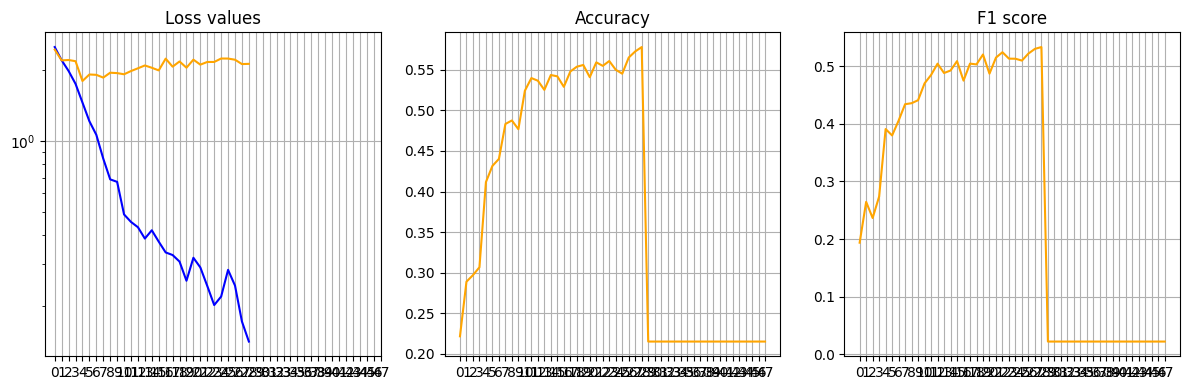

Current LR: 3.125e-05


  1%|          | 1/172 [00:09<26:14,  9.21s/it]


KeyboardInterrupt: 

In [ ]:
# NUM_EPOCHS = 50

# #  Обучение модели
# model = Model9().to(device)

# loss_function = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.Adam(model.parameters(), 
#                            lr=0.001,
#                            weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


# train_loss_hist = []
# test_loss_hist = []
# accuracy = []
# f1 = []

# for i in range(NUM_EPOCHS):

#     train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
#     train_loss_hist.append(train_loss)

#     test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
#     test_loss_hist.append(test_loss)

#     accuracy.append(acc)
#     f1.append(f1_)

#     scheduler.step(f1_)
    
#     if f1[-1] == max(f1):
#         torch.save(model, 'resnet_best_model.pth')
#         torch.save(model.state_dict(), 'resnet_best_weights.pth')

#     show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
#     print(f"Current LR: {optimizer.param_groups[0]['lr']}")



# print(f"Min loss: {min(test_loss_hist)}")
# print(f"Max Accuracy: {max(accuracy)}")
# print(f"Max F1: {max(f1)}")

In [14]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [ ]:
# model = torch.load('model9_best_model.pth', weights_only=False)
# model

Model9(
  (block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_p

In [35]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 15/15 [00:48<00:00,  3.25s/it]

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       399
           1       0.23      0.29      0.26        21
           2       0.35      0.38      0.36        87
           3       0.61      0.45      0.52       264
           4       0.54      0.70      0.61        83
           5       0.50      0.66      0.57       145
           6       0.62      0.63      0.62       121
           7       0.56      0.66      0.61        65
           8       0.79      0.67      0.73       186
           9       0.47      0.46      0.46        61
          10       0.47      0.47      0.47        79
          11       0.64      0.76      0.70        63
          12       0.35      0.26      0.30        68
          13       0.37      0.37      0.37        30
          14       0.61      0.60      0.60       129
          15       0.69      0.75      0.72        55

    accuracy                           0.58      1856
   macro avg       0.53   

In [22]:
# import torch
# torch.cuda.empty_cache()  

In [ ]:
class Model10(nn.Module):
    def __init__(self):
        super(Model10, self).__init__()

        self.block1 = nn.Sequential(  # (3, 200, 200)
            nn.Conv2d(3, 8, kernel_size=11, stride=1, padding=1),  # (8, 192, 192)
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((128, 128)),  # (8, 128, 128)

            nn.Conv2d(8, 16, kernel_size=11, stride=1, padding=1),  # (16, 120, 120)
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((64, 64)),  # (16, 64, 64)
        )

        # (16, 64, 64)

        # --------------BigSkip--------------
        # --------------skip1--------------
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (32, 64, 64)
            nn.BatchNorm2d(32),
            # nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 32, 32)

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(), # (32, 32, 32)
        )
        # --------------skip1--------------


        # --------------skip2--------------
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 32, 32)
            nn.BatchNorm2d(64),
            # nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 16, 16)

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.PReLU(),
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2), # (128, 8, 8)
        )
        # --------------skip2--------------


        # --------------skip3--------------
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            # nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (256, 4, 4)
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.PReLU(),
        
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),  # (512, 2, 2)
        )
        # --------------skip3--------------
        # --------------BigSkip--------------

        # (512, 2, 2)



        self.skip1 = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (32, 32, 32)
            nn.BatchNorm2d(32),
            nn.PReLU(),  # (32, 32, 32)
        )

        self.skip2 = nn.Sequential(  # (32, 32, 32)
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (128, 8, 8)
        )
        
        self.skip3 = nn.Sequential(  # (128, 8, 8)
            nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=1),  # (512, 4, 4) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (512, 2, 2)
        )

        self.bigskip = nn.Sequential(  # (16, 64, 64)
            nn.Conv2d(16, 128, kernel_size=3, stride=2, padding=1),  # (128, 32, 32) 
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # (128, 16, 16) 

            nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=1),  # (512, 8, 8) 
            nn.BatchNorm2d(512),
            nn.PReLU(),
            nn.AdaptiveAvgPool2d((2, 2)),  # (512, 2, 2)
        )


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 2 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )

    def forward(self, x):
        x = self.block1(x)
        bigskip = self.bigskip(x)

        skip = self.skip1(x)
        out = self.block2(x)
        x = skip + out

        out = self.block3(x)
        skip = self.skip2(x)
        x = skip + out

        out = self.block4(x)
        skip = self.skip3(x)
        x = skip + out + bigskip
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [22]:
model = Model10().to(device)
summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 192, 192]           2,912
       BatchNorm2d-2          [-1, 8, 192, 192]              16
             PReLU-3          [-1, 8, 192, 192]               1
 AdaptiveAvgPool2d-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 120, 120]          15,504
       BatchNorm2d-6         [-1, 16, 120, 120]              32
             PReLU-7         [-1, 16, 120, 120]               1
 AdaptiveAvgPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]          18,560
      BatchNorm2d-10          [-1, 128, 32, 32]             256
            PReLU-11          [-1, 128, 32, 32]               1
        AvgPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 512, 8, 8]         590,336
      BatchNorm2d-14            [-1, 51

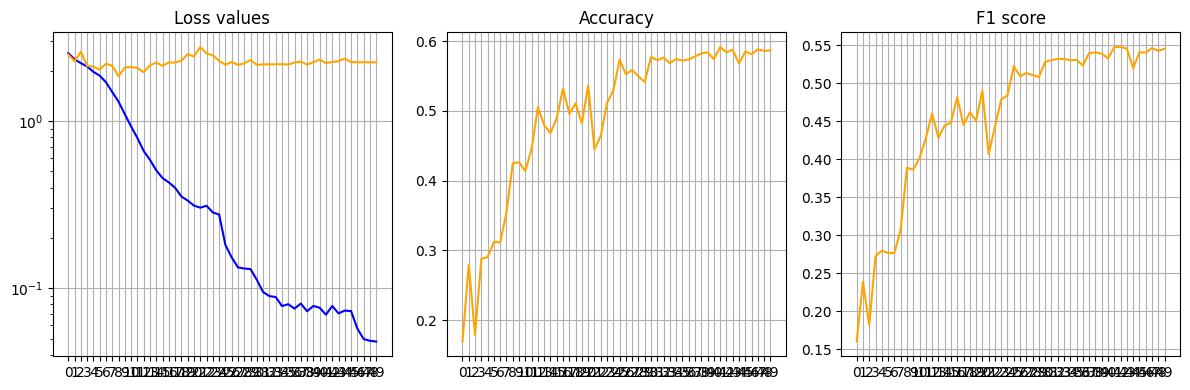

Current LR: 6.25e-05
Min loss: 1.8510898979086625
Max Accuracy: 0.5915948275862069
Max F1: 0.5473318620340532


In [24]:
NUM_EPOCHS = 50

#  Обучение модели
model = Model10().to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), 
                           lr=0.001,
                           weight_decay=1e-4
                           )
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for i in range(NUM_EPOCHS):

    train_loss, acc, f1_ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1[-1] == max(f1):
        torch.save(model, 'model10_best_model.pth')
        torch.save(model.state_dict(), 'model10_best_weights.pth')

    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")



print(f"Min loss: {min(test_loss_hist)}")
print(f"Max Accuracy: {max(accuracy)}")
print(f"Max F1: {max(f1)}")

In [25]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:40<00:00,  2.11s/it]

              precision    recall  f1-score   support

           0       0.70      0.60      0.65       399
           1       0.33      0.24      0.28        21
           2       0.44      0.40      0.42        87
           3       0.55      0.50      0.52       264
           4       0.54      0.67      0.60        83
           5       0.57      0.69      0.62       145
           6       0.52      0.64      0.58       121
           7       0.55      0.60      0.57        65
           8       0.81      0.63      0.71       186
           9       0.36      0.52      0.43        61
          10       0.49      0.56      0.52        79
          11       0.73      0.78      0.75        63
          12       0.40      0.34      0.37        68
          13       0.36      0.33      0.34        30
          14       0.61      0.67      0.64       129
          15       0.67      0.76      0.71        55

    accuracy                           0.59      1856
   macro avg       0.54   

In [16]:
model = torch.load('model4_16_best_model.pth', weights_only=False)


In [23]:
from sklearn.metrics import classification_report

y_true, y_pred = predict(model, valid_loader)

print(classification_report(y_true, y_pred))

100%|██████████| 19/19 [00:29<00:00,  1.56s/it]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       399
           1       0.23      0.90      0.37        21
           2       0.96      0.90      0.93        87
           3       0.92      0.95      0.93       264
           4       0.93      1.00      0.97        83
           5       0.99      0.92      0.95       145
           6       0.94      0.98      0.96       121
           7       0.91      0.92      0.92        65
           8       0.98      0.95      0.97       186
           9       0.00      0.00      0.00        61
          10       0.00      0.00      0.00        79
          11       0.00      0.00      0.00        63
          12       0.00      0.00      0.00        68
          13       0.00      0.00      0.00        30
          14       0.00      0.00      0.00       129
          15       0.00      0.00      0.00        55

    accuracy                           0.70      1856
   macro avg       0.49   


z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
z:\projects\Yandex Kaggle\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for img_name in tqdm(test_set.image_files):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image)
        
        output = model(image.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])
        test_preds.append(pred.item())

test_ids, test_preds = zip(*sorted(zip(test_ids, test_preds), key=lambda x: int(x[0])))

with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, [index_to_target[p] for p in test_preds]))


100%|██████████| 5301/5301 [01:42<00:00, 51.76it/s]
